In [196]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

1.10.1
True


In [197]:
import torch
print(torch.cuda.current_device())
print(torch.cuda.device_count())

0
2


In [198]:
import os
import pandas as pd
import numpy as np #for transformation
import matplotlib.pyplot as plt #for plotting
from pathlib import Path
from sklearn.model_selection import train_test_split

import torch #pytorch package
import torch.nn as nn #basic building block for neural neteorks
import torch.nn.functional as F #import convolution functions like Relu
import torchvision
import torchvision.transforms as transforms #image transformation (cuz' the insufficiency of our data)
import torchvision.models as models #for finetune #commonly used model structures (including pre-trained models), such as AlexNet, VGG, ResNet, etc.
import torch.optim as optim #for optimize model(SGD, Adam, etc.)

#test
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid

In [5]:
%pwd

'C:\\Users\\user\\Desktop\\李忠\\AI_final'

In [155]:
# 日常使用代码：将某个文件夹及其子目录下的所有图片格式改为.JPG格式
import os
import re

path='./imgs'
file_walk = os.walk(path)
fileNum = 0
filesPathList = []
for root, dirs, files in file_walk:
    # print(root, end=',')
    # print(dirs, end=',')
    # print(files)
    for file in files:
        fileNum = fileNum + 1
        filePath = root + '/' + file
        #print(filePath)
        filesPathList.append(filePath)
        protion = os.path.splitext(filePath)
        #print(protion[0],protion[1])
        if protion[1].lower() != '.jpg':
            #print("正在处理：" + filePath)
            newFilePath = protion[0] + '.jpg'
            os.rename(filePath, newFilePath)
    print("這個dir已轉檔完成")

這個dir已轉檔完成
這個dir已轉檔完成
這個dir已轉檔完成
這個dir已轉檔完成
這個dir已轉檔完成
這個dir已轉檔完成
這個dir已轉檔完成
這個dir已轉檔完成
這個dir已轉檔完成
這個dir已轉檔完成


In [156]:
#training data
import glob
image= Path('imgs')
ext = ['png', 'jpg', 'gif','jfif','jpeg']# Add image formats here
file = []
[file.extend(image.glob(r'**/*.' + e)) for e in ext]

#file= list(image.glob('*.'+e) for e in ext)
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file))
file= pd.Series(file, name='File').astype(str)
labels = pd.Series(labels, name='Label')

train_df= pd.concat([file, labels], axis=1)
train_df['Label'].value_counts()

美国队长    339
洛基      335
浩克      332
蚁人      329
黑寡妇     326
奇异博士    314
钢铁侠     313
灭霸      311
蜘蛛侠     311
Name: Label, dtype: int64

In [138]:
#確認資料寬高最大最小值
from os import listdir
from os.path import isfile, join

from PIL import Image


def print_data(data):
    """
    Parameters
    ----------
    data : dict
    """
    print("Min width: %i" % data["min_width"])
    print("Max width: %i" % data["max_width"])
    print("Min height: %i" % data["min_height"])
    print("Max height: %i" % data["max_height"])


def main(path):
    """
    Parameters
    ----------
    path : str
        Path where to look for image files.
    """
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    # Filter files by extension
    onlyfiles = [f for f in onlyfiles if f.endswith(".jpg")]

    data = {}
    data["images_count"] = len(onlyfiles)
    data["min_width"] = 10 ** 100  # No image will be bigger than that
    data["max_width"] = 0
    data["min_height"] = 10 ** 100  # No image will be bigger than that
    data["max_height"] = 0

    for filename in onlyfiles:
        filename = str(path + '/'+filename)
        im = Image.open(filename)
        width, height = im.size
        data["min_width"] = min(width, data["min_width"])
        data["max_width"] = max(width, data["max_width"])
        data["min_height"] = min(height, data["min_height"])
        data["max_height"] = max(height, data["max_height"])

    print_data(data)


if __name__ == "__main__":
    main(path="marvel/train/black widow")

Min width: 143
Max width: 5401
Min height: 140
Max height: 3601


In [114]:
#計算Normalization的mean跟sd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os
from tqdm import tqdm

transform = transforms.Compose(
[   transforms.Resize([128, 128]),
    transforms.ToTensor()
])
train_path = 'imgs/'
trainset = torchvision.datasets.ImageFolder(root=train_path, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset))
####### COMPUTE MEAN / STD

# placeholders
psum    = torch.tensor([0.0, 0.0, 0.0])
psum_sq = torch.tensor([0.0, 0.0, 0.0])
# loop through images
for inputs in tqdm(trainloader):
#     print(inputs)
#     inputs = np.asarray(inputs)
#     inputs = np.squeeze(inputs)
#     print(inputs.shape())
#     psum    += np.array(inputs[0]).sum(axis = [0, 2, 3])#B C H W 要求每C2的
    inputs = inputs[0]
    psum    += inputs.sum(axis = (0, 2, 3))
    psum_sq += (inputs ** 2).sum(axis = (0, 2, 3))
    
####### FINAL CALCULATIONS

# pixel count
image_size = 128
count = len(trainset) * image_size * image_size

# mean and std
total_mean = psum / count
total_var  = (psum_sq/count) - (total_mean ** 2)

total_std  = torch.sqrt(total_var)

# output
print('mean: '  + str(total_mean))
print('std:  '  + str(total_std))

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:27<00:00, 27.33s/it]

mean: tensor([0.3850, 0.3505, 0.3395])
std:  tensor([0.3048, 0.2915, 0.2879])


In [ ]:
# transform=transforms.Compose([
#  # Random表示有可能做，所以也可能不做
# transforms.RandomHorizontalFlip(),# 水平翻转
# transforms.RandomVerticalFlip(), # 上下翻转
# transforms.RandomRotation(15), # 随机旋转-15°~15°
# transforms.RandomRotation([90, 180]), # 随机在90°、180°中选一个度数来旋转，如果想有一定概率不旋转，可以加一个0进去
# transforms.RandomCrop([28, 28]),
# ])

In [199]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

batch_size = 16

train_path = 'imgs/'

# mean: tensor([0.3850, 0.3505, 0.3395])
# std:  tensor([0.3048, 0.2915, 0.2879])

transforms = transforms.Compose(
[   
    transforms.Resize([128,128]),
    transforms.ToTensor(),
    transforms.Normalize([0.3850, 0.3505, 0.3395],[0.3048, 0.2915, 0.2879])
])


allset = datasets.ImageFolder(root=train_path, transform=transforms)
print(allset.class_to_idx)
total_count = len(allset)
print(f"total count : {total_count}")
train_count = int(0.7 * total_count) 
valid_count = int(0.2 * total_count)
test_count = total_count - train_count - valid_count
trainset ,validset ,testset = torch.utils.data.random_split(allset, (train_count, valid_count, test_count))
print('train num',train_count)
print('valid num',valid_count)
print('test num',test_count)

trainloader = DataLoader(trainset, batch_size=16, shuffle=True)
validloader = DataLoader(validset, batch_size=16, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(128,512))
    plt.subplot(3,3,1)
    plt.imshow(inp)
    plt.pause(0.001)
    
images, labels = next(iter(trainloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

# imshow(out)

{'奇异博士': 0, '洛基': 1, '浩克': 2, '灭霸': 3, '美国队长': 4, '蚁人': 5, '蜘蛛侠': 6, '钢铁侠': 7, '黑寡妇': 8}
total count : 2910
train num 2036
valid num 582
test num 292
images-size: torch.Size([16, 3, 128, 128])
out-size: torch.Size([3, 262, 1042])


In [341]:
net = models.resnet34(pretrained=True)
net = nn.DataParallel(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9,weight_decay=0.01)
#optimizer = optim.Adam(net.parameters(),lr=0.0001,weight_decay=0.1)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1) #lr 隨迭代改變
net.module.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features=512, out_features=9, bias=True),
    #torch.nn.ReLU(inplace=True),
    #torch.nn.Linear(in_features=128, out_features=8, bias=True)
)
net = net.cuda() if device else net

In [342]:
%%time
early_stop = 0
n_epochs = 50
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(trainloader)
valid_result = pd.DataFrame(columns=['pred', 'target'])
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(trainloader):
        data_, target_ = data_.to(device), target_.to(device)
        
        outputs = net(data_)
        optimizer.zero_grad()
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 16 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (validloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            pred_t = pred_t.cpu()
            target_t = target_t.cpu()
            valid_result = valid_result.append({'pred':pred_t ,'target':target_t },ignore_index=True)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(testloader))
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')
        if batch_loss < valid_loss_min:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
            early_stop = 0
        else :
            early_stop += 1
    if early_stop == 5 :
        print("Early Stop!")
        break
    #exp_lr_scheduler.step()#改變學習率
    net.train()
print("Train End~")
valid_result.to_csv('分類結果.csv',index=False)

Epoch 1

Epoch [1/50], Step [0/128], Loss: 3.0384
Epoch [1/50], Step [16/128], Loss: 2.7707
Epoch [1/50], Step [32/128], Loss: 1.9178
Epoch [1/50], Step [48/128], Loss: 2.3518
Epoch [1/50], Step [64/128], Loss: 2.3976
Epoch [1/50], Step [80/128], Loss: 2.0879
Epoch [1/50], Step [96/128], Loss: 2.4478
Epoch [1/50], Step [112/128], Loss: 2.1800

train-loss: 2.4874, train-acc: 12.4754
validation loss: 1.6055, validation acc: 16.6667

Improvement-Detected, save-model
Epoch 2

Epoch [2/50], Step [0/128], Loss: 2.3403
Epoch [2/50], Step [16/128], Loss: 2.1243
Epoch [2/50], Step [32/128], Loss: 2.1556
Epoch [2/50], Step [48/128], Loss: 2.4782
Epoch [2/50], Step [64/128], Loss: 2.2006
Epoch [2/50], Step [80/128], Loss: 1.8753
Epoch [2/50], Step [96/128], Loss: 2.2863
Epoch [2/50], Step [112/128], Loss: 1.9931

train-loss: 2.3074, train-acc: 22.2004
validation loss: 1.4812, validation acc: 27.1478

Improvement-Detected, save-model
Epoch 3

Epoch [3/50], Step [0/128], Loss: 1.5638
Epoch [3/50], 

Epoch [18/50], Step [80/128], Loss: 0.3425
Epoch [18/50], Step [96/128], Loss: 0.4488
Epoch [18/50], Step [112/128], Loss: 0.6940

train-loss: 1.0416, train-acc: 91.2574
validation loss: 0.7598, validation acc: 80.9278

Improvement-Detected, save-model
Epoch 19

Epoch [19/50], Step [0/128], Loss: 0.4018
Epoch [19/50], Step [16/128], Loss: 0.2067
Epoch [19/50], Step [32/128], Loss: 0.3129
Epoch [19/50], Step [48/128], Loss: 0.3594
Epoch [19/50], Step [64/128], Loss: 0.4202
Epoch [19/50], Step [80/128], Loss: 0.2374
Epoch [19/50], Step [96/128], Loss: 0.3366
Epoch [19/50], Step [112/128], Loss: 0.4821

train-loss: 1.0082, train-acc: 91.1591
validation loss: 0.7437, validation acc: 81.6151

Epoch 20

Epoch [20/50], Step [0/128], Loss: 0.6084
Epoch [20/50], Step [16/128], Loss: 0.2422
Epoch [20/50], Step [32/128], Loss: 0.3392
Epoch [20/50], Step [48/128], Loss: 0.5048
Epoch [20/50], Step [64/128], Loss: 0.4898
Epoch [20/50], Step [80/128], Loss: 0.3652
Epoch [20/50], Step [96/128], Loss: 

Epoch [36/50], Step [80/128], Loss: 0.1420
Epoch [36/50], Step [96/128], Loss: 0.0659
Epoch [36/50], Step [112/128], Loss: 0.1478

train-loss: 0.6537, train-acc: 98.3792
validation loss: 0.5823, validation acc: 83.6770

Improvement-Detected, save-model
Epoch 37

Epoch [37/50], Step [0/128], Loss: 0.0952
Epoch [37/50], Step [16/128], Loss: 0.2044
Epoch [37/50], Step [32/128], Loss: 0.1017
Epoch [37/50], Step [48/128], Loss: 0.1390
Epoch [37/50], Step [64/128], Loss: 0.0910
Epoch [37/50], Step [80/128], Loss: 0.0867
Epoch [37/50], Step [96/128], Loss: 0.1574
Epoch [37/50], Step [112/128], Loss: 0.0998

train-loss: 0.6404, train-acc: 97.4460
validation loss: 0.5774, validation acc: 82.8179

Epoch 38

Epoch [38/50], Step [0/128], Loss: 0.0616
Epoch [38/50], Step [16/128], Loss: 0.0866
Epoch [38/50], Step [32/128], Loss: 0.2321
Epoch [38/50], Step [48/128], Loss: 0.1431
Epoch [38/50], Step [64/128], Loss: 0.4787
Epoch [38/50], Step [80/128], Loss: 0.0929
Epoch [38/50], Step [96/128], Loss: 

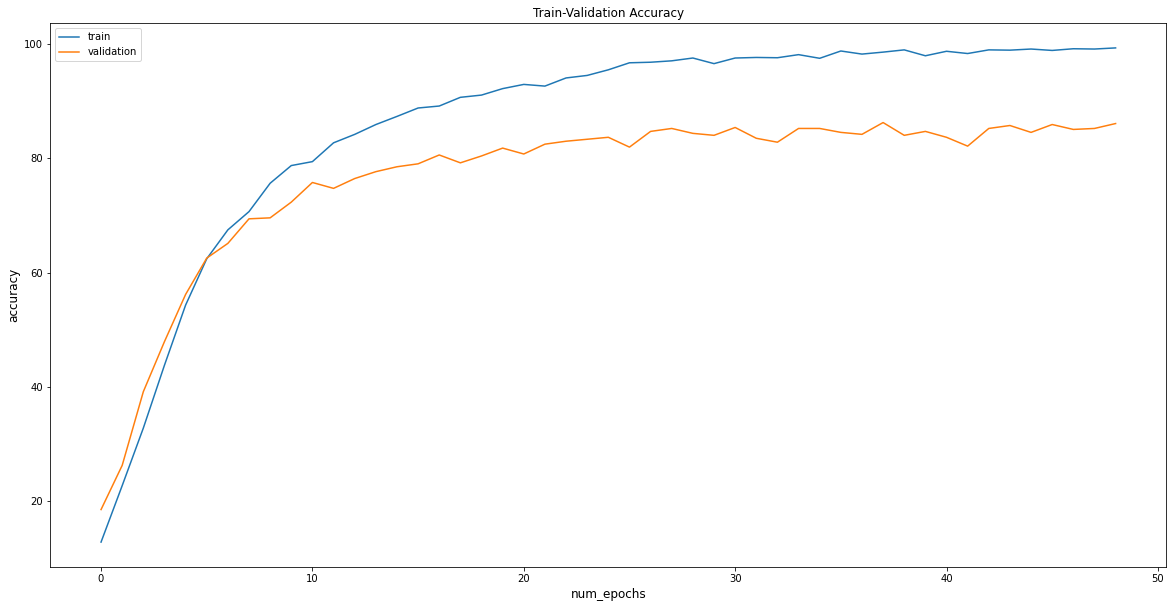

In [339]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [318]:
PATH = './resnet.pt'

In [310]:
# load back in our saved model
net.load_state_dict(torch.load(PATH))
#testloader = DataLoader(testset, batch_size=16, shuffle=True)

<All keys matched successfully>

In [311]:
new_testset = torch.utils.data.ConcatDataset([testset, validset])

In [297]:
len(new_testset)

874

In [253]:
len(validset)

582

In [250]:
len(testset)

292

In [312]:
testloader = DataLoader(new_testset, batch_size=16, shuffle=True)

In [344]:
%%time
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 874 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 874 test images: 82 %
Wall time: 10.5 s


In [320]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("The num of the class is {},Accuracy for class {:5s} is: {:.1f} %".format(total_pred[classname],classname,
                                                   accuracy))

The num of the class is 86,Accuracy for class 0     is: 86.0 %
The num of the class is 105,Accuracy for class 1     is: 90.5 %
The num of the class is 116,Accuracy for class 2     is: 92.2 %
The num of the class is 101,Accuracy for class 3     is: 82.2 %
The num of the class is 103,Accuracy for class 4     is: 85.4 %
The num of the class is 93,Accuracy for class 5     is: 59.1 %
The num of the class is 90,Accuracy for class 6     is: 77.8 %
The num of the class is 90,Accuracy for class 7     is: 83.3 %
The num of the class is 90,Accuracy for class 8     is: 90.0 %
